# Analysis cookbook: Effective Xarray for analysis of Trajectory output

Analysing CF compliant trajectory data output from simulation frameworks such as [Parcels](https://oceanparcels.org/) is important for understanding the movement of the particles being simulated and their properties. Learning how to effectively leverage Xarray in this analysis enables researchers quickly create analysis code that is efficient, and readable - sticking close to convenient abstractions provided by Xarray where possible.

Note that in this notebook we use type annotations. e.g.,

```python
def my_function(x: int) -> int:
    return x + 1
```

this is absolutely equivalent to

```python
def my_function(x):
    return x + 1
```
but it just provides some additional information about the function signature (that it accepts an argument `x` of type `int` and returns an `int`).

## Notebook requirements

This notebook requires the following packages. The versions printed are the ones used when this notebook was created, but newer versions should work as well.

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from typing import Tuple
from IPython.display import display

# TODO: Patch with actual downloading of dataset
project_home = Path("/Users/Hodgs004/coding/repos/Lagrangian_diags")
path = project_home / "data/singletime_repeat.zarr"

def print_required_packages():
    for mod in [xr, np, matplotlib, shapely, pd]:
        print(mod.__name__, mod.__version__)

print_required_packages()


xarray 2025.1.2
numpy 2.2.3
matplotlib 3.10.1
shapely 2.0.7
pandas 2.2.3


In [2]:
ds = xr.open_dataset(path, decode_timedelta = False)

In [3]:
ds

<xarray.Dataset> Size: 20MB
Dimensions:     (trajectory: 3420, obs: 180)
Coordinates:
  * obs         (obs) int32 720B 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 27kB 0 1 2 3 4 5 ... 3415 3416 3417 3418 3419
Data variables:
    lat         (trajectory, obs) float64 5MB ...
    lon         (trajectory, obs) float64 5MB ...
    time        (trajectory, obs) float64 5MB ...
    z           (trajectory, obs) float64 5MB ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4DeleteErrorParticle
    parcels_mesh:           spherical
    parcels_version:        3.0.1

(<Figure size 640x480 with 1 Axes>, <Axes: >)

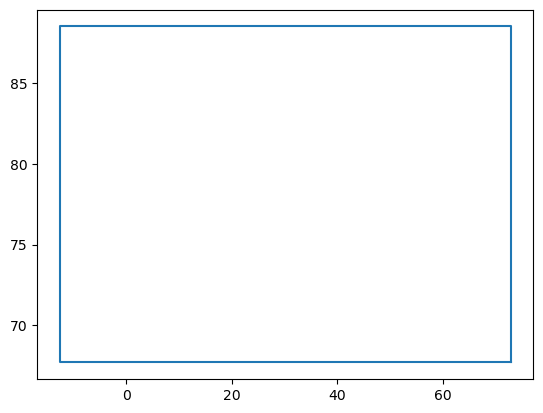

In [ ]:
import matplotlib.axes
import matplotlib.figure

DOMAIN_LON = ds.lon.min(), ds.lon.max()
DOMAIN_LAT = ds.lat.min(), ds.lat.max()

def scatter_traj_dataset(ds: xr.Dataset, color: xr.DataArray | None = None, ax: matplotlib.axes.Axes | None = None) -> matplotlib.axes.Axes:
    """Plot the lat/lon of the observations colouring based on `target` (if provided).
    
    Dataset should be in the obs/traj format in the form of an xr.Dataset.
    """
    if ax is None:
        _, ax = plt.subplots()
        ax.set_xlim(DOMAIN_LON)
        
    
    ax.scatter(ds.lon, ds.lat, c=color, cmap="viridis", marker='.')
    return ax

def get_bbox(ds: xr.Dataset) -> shapely.geometry.Polygon:
    """Return the bounding box of the dataset.
    """
    return shapely.geometry.box(ds.lon.min(), ds.lat.min(), ds.lon.max(), ds.lat.max())



def plot_polygon(poly: shapely.geometry.Polygon, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(*poly.exterior.xy)
    return fig, ax

plot_polygon(get_bbox(ds))

# ds.isel(trajectory=0).pipe(scatter_traj_dataset)



In [5]:
ds_trim = ds.isel(trajectory=slice(0, 3420, 10)) # trimming down the dataset for plotting


/var/folders/j5/x0w7f5sn7gg25__6pg48j82c0000gn/T/ipykernel_46204/1195154642.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(ds.lon, ds.lat, c=color, cmap="viridis", marker='.')


<Axes: >

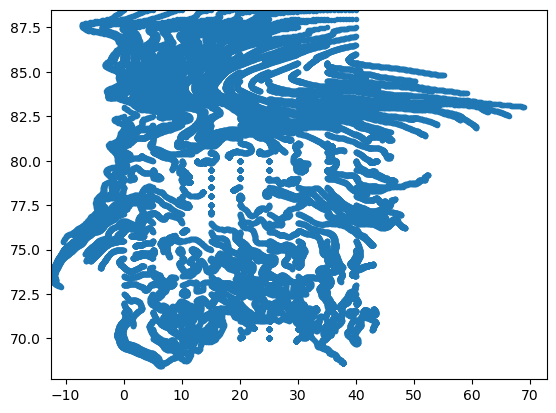

In [6]:
scatter_traj_dataset(ds_trim)

## Per-observation analysis

Sometimes there are metrics that we want to compute for each observation in a trajectory dataset. Perhaps we're interested in if the observation is in a specific location (i.e., a calculation with lon/lat), or we are interested if another variable has a specific value.

This can be easily done with Xarray using array operations using conditional statements with the variables in our dataset. PLUS this has the benefit of being lazily computed via Dask, meaning the computation is only done when the result is needed during plotting or writing - win, win, win.

In [ ]:
def north_of_line(ds: xr.Dataset, p0: Tuple[float, float], p1: Tuple[float, float]) -> xr.DataArray:
    """Return a boolean array indicating whether each point is North of a line (specified by 2 points, extended infinitely).
    
    This line is simply a line between p0 and p1 in lon/lat space without accounting for earth curvature.
    
    Doesn't work for lines running directly North-South.
    """
    lon0, lat0 = p0
    lon1, lat1 = p1
    assert not np.isclose(np.array(p0), np.array(p1)).all(), "Points are the same"
    assert lon0 != lon1, "Doesn't work for vertical lines"

    m = (lat1 - lat0) / (lon1 - lon0)
    c = lat0 - m * lon0

    return ds.lat > m * ds.lon + c


<xarray.DataArray (trajectory: 342, obs: 180)> Size: 62kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(342, 180))
Coordinates:
  * obs         (obs) int32 720B 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 3kB 0 10 20 30 40 ... 3380 3390 3400 3410

<Axes: >

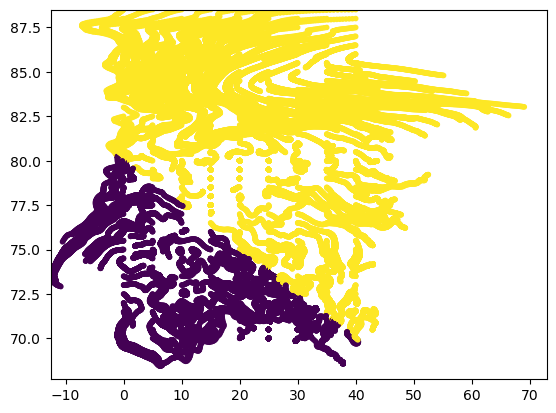

In [ ]:
is_north_of_line = north_of_line(ds_trim, p0=(0, 80), p1=(40, 70))
display(is_north_of_line)
scatter_traj_dataset(ds_trim, color=is_north_of_line)

<Axes: title={'center': 'In neither band'}>

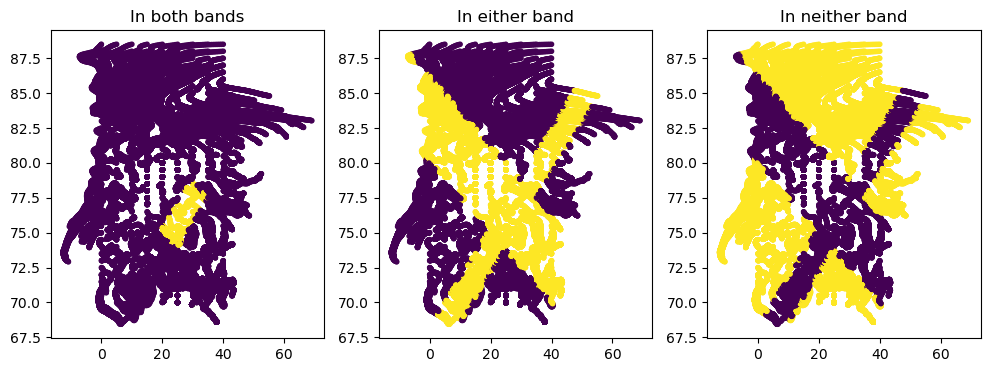

In [10]:
in_band1 = (
    north_of_line(ds_trim, p0=(0, 80), p1=(40, 70))
    & ~north_of_line(ds_trim, p0=(5, 85), p1=(45, 75))
)
in_band2 = (
    north_of_line(ds_trim, p0=(0, 65), p1=(70, 90))
    & ~north_of_line(ds_trim, p0=(5, 70), p1=(75, 95))
    )


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].set_title("In both bands")
axs[1].set_title("In either band")
axs[2].set_title("In neither band")

scatter_traj_dataset(ds_trim, color=(in_band1 & in_band2), ax=axs[0])
scatter_traj_dataset(ds_trim, color=(in_band1 | in_band2), ax=axs[1])
scatter_traj_dataset(ds_trim, color=(~in_band1 & ~in_band2), ax=axs[2])




## 

### More complex per-observation analysis

A common thing that we may want to do is calculate if a point is in a specific region, that isn't easily defined by simple lines in lat/lon space (e.g, to find if particles are in an Exclusive Economic Zone).

This can be done by levaging [Shapely](https://shapely.readthedocs.io/en/stable/), a package providing geospatial support in Python for vector features - points, lines, and polygons. As an FYI: Shapely is also used by [GeoPandas](https://geopandas.org/en/stable/), a popular package for working with tabular geospatial data in Python. Shapely by itself suffices for our purposes here.

In the 

TODO: Look at doing the polygons in a different projection
https://racum.blog/articles/projection-shapely/






type(heart_polygon)=<class 'shapely.geometry.polygon.Polygon'>


Text(0.5, 1.0, 'Heart shape geo-polygon')

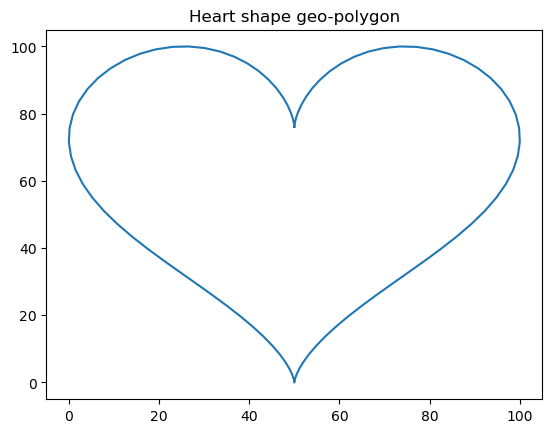

In [11]:
def in_polygon(ds, poly: shapely.geometry.Polygon) -> xr.DataArray:
    """Return a boolean array indicating whether each point is in the given polygon.

    `shapely.points(...)` allows for the creation of points from arrays of lon/lat
    `shapely.geometry.Polygon.contains` is also compatible with arrays of points
    """
    array = poly.contains(shapely.points(ds.lon, ds.lat))
    return xr.DataArray(array, coords=ds.coords) # Adding back the dimension information, as shapely didn't carry it through

class TestData:
    """Class just for the namespace."""
    @staticmethod
    def get_heart_geo_polygon(xmin, xmax, ymin, ymax):
        """Return a shapely Polygon of a heart shape in the desired bounding box."""
        t = np.linspace(0, 2 * np.pi, 100)
        x = 16 * np.sin(t)**3
        y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)
        heart_points = list(zip(x, y))

        x, y = zip(*heart_points)
        x, y = TestData.rescale_xy(x, y, xmin, xmax, ymin, ymax)
        return shapely.geometry.Polygon(zip(x, y))

    @staticmethod
    def rescale_xy(x, y, xmin, xmax, ymin, ymax):
        x = np.array(x)
        y = np.array(y)
        x = (x - x.min()) / (x.max() - x.min()) * (xmax - xmin) + xmin
        y = (y - y.min()) / (y.max() - y.min()) * (ymax - ymin) + ymin
        return x, y

heart_polygon = TestData.get_heart_geo_polygon(0, 100, 0, 100)

print(f"{type(heart_polygon)=}")

fig, ax = plot_polygon(heart_polygon)
ax.set_title("Heart shape geo-polygon")

<Axes: >

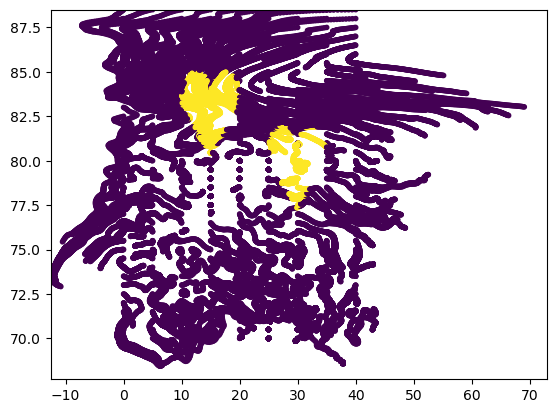

In [12]:
in_hearts = (
    in_polygon(ds_trim, TestData.get_heart_geo_polygon(10, 20, 80, 85))
    | in_polygon(ds_trim, TestData.get_heart_geo_polygon(25, 35, 77, 82))
)
scatter_traj_dataset(ds_trim, color=in_hearts)



## Between observation analysis

We may want to compare an observation to the next observation. For example:

- calculating meriodonal or zonal velocity (degrees/s)
- if we want to see when particles are travelling in a specific direction
- if we want to see when a particle *crosses* a line (instead of if its simply above that line)

Fundamentally, these properties are no longer about the individual observations, but about the gaps between them. e.g.,

In [13]:
x = np.array([1,2,3])

display(x)
display(np.diff(x))

array([1, 2, 3])

array([1, 1])

Note that these arrays are of different shape. To make them the same shape we can either pad the beginning or the end with `np.nan` or `None` values. Whether we pad the beginning or the end of the data only affects our interprettation of the data. Here we just pad at the end.


## Reduction

In [14]:
def degrees_velocity(ds: xr.Dataset) -> xr.DataArray:
    ds.diff()

3420

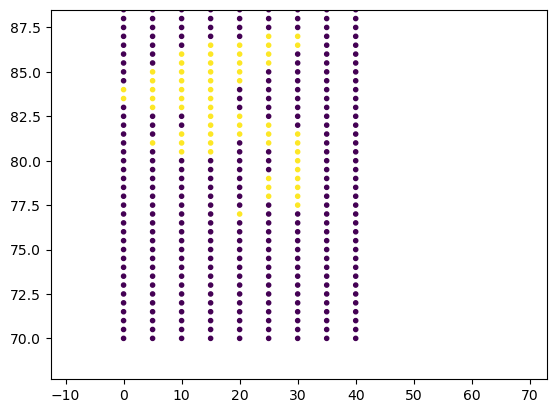

In [15]:
ever_in_heart = in_hearts.any(dim='obs')


scatter_traj_dataset(ds_trim.isel(obs=0), color=ever_in_heart)

ds.trajectory.size

In [16]:
import matplotlib.pyplot as plt





# More examples



In [ ]:
def check_first_crossing_into_x(ds: xr.Dataset):
    """OK. A quick example to show what is possible. This will be cleaned up later and uploaded..."""
    in_band1 = (
        north_of_line(ds, p0=(0, 80), p1=(40, 70))
        & ~north_of_line(ds, p0=(5, 85), p1=(45, 75))
    )
    in_band2 = (
        north_of_line(ds, p0=(0, 65), p1=(70, 90))
        & ~north_of_line(ds, p0=(5, 70), p1=(75, 95))
        )
    
    ds["in_x"] = in_band1 & in_band2
    ds["ever_in_x"] = ds["in_x"].any(dim='obs')
    # return ds
    # filter down to only the particles that enter the X
    ds = ds.sel(trajectory=ds.ever_in_x)
    return ds

particles_in_x =  check_first_crossing_into_x(ds_trim)
obs_entering_x = particles_in_x["in_x"].argmin(dim="obs")
particles_in_x.isel(obs=obs_entering_x).time.values

array([ 561600., 2116800.,       0., 2203200.,       0., 3801600.,
             0.,       0.,  993600.,       0.,       0.,       0.,
       1296000.,       0.,       0., 1339200., 3196800.,       0.,
       1555200.,       0., 1036800.,       0.])

In [18]:
enter_exit = particles_in_x['in_x'].astype(int).diff(dim='obs').pipe(np.abs).sum(dim='obs')

enter = particles_in_x['in_x'].astype(int).diff(dim='obs').pipe(np.greater, 0).sum(dim='obs')
exit_ = particles_in_x['in_x'].astype(int).diff(dim='obs').pipe(np.less, 0).sum(dim='obs')

enter_exit == enter + exit_



<xarray.DataArray 'in_x' (trajectory: 22)> Size: 22B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
  * trajectory  (trajectory) int64 176B 770 860 940 950 ... 1500 1580 1590 1670

In [19]:
ds_trim

<xarray.Dataset> Size: 2MB
Dimensions:     (trajectory: 342, obs: 180)
Coordinates:
  * obs         (obs) int32 720B 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * trajectory  (trajectory) int64 3kB 0 10 20 30 40 ... 3380 3390 3400 3410
Data variables:
    lat         (trajectory, obs) float64 492kB 70.0 69.98 69.96 ... 84.55 84.52
    lon         (trajectory, obs) float64 492kB 0.0 0.02257 ... 5.882 5.835
    time        (trajectory, obs) float64 492kB ...
    z           (trajectory, obs) float64 492kB ...
    in_x        (trajectory, obs) bool 62kB False False False ... False False
    ever_in_x   (trajectory) bool 342B False False False ... False False False
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4DeleteErrorParticle
    parcels_mesh:           spherical
    parcels_version:        3.0.1

In [20]:
in_hearts.argmin(dim="obs")

<xarray.DataArray (trajectory: 342)> Size: 3kB
array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   8,   0,
         0,   0,   0,   0,   0,   0,   0,  26,   0,   0,   0,   0,   0,
         0,   0,   0,  32,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  46,   0,   0,
         0,   0,   0,   0,   0,   0,  30,   0,   0,   0,   0,   0,   0,
         0,   0,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  73,   0,   0,   0,   0,   0,
         0,   0,   0, 138,   0,   0,   0,   0,   0,   0,   0,   0,  36,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])
Coordinates:
  * trajectory  (trajectory) int64 3kB 0 10 20 30 40 ... 3380 3390 3400 3410

TODO: look at CLOUD-DRIFT datasets on zenodo

TODO: Working in different projections (creating the polygon in a different projection, then reprojecting into lon/lat space for the analysis) [META: maybne just add the TODO comment in the notebook]






